Full bytes with CRC:
0x8d 0x40 0x6b 0x90 0x20 0x15 0xa6 0x78 0xd4 0xd2 0x20 0xaa 0x4b 0xda 

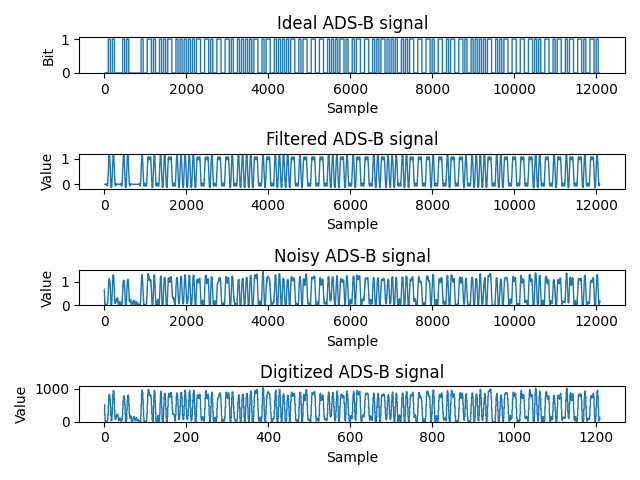

In [1]:
%matplotlib widget
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from Functions.signal_generator import signal_start_pause_length, generate_ADSB, \
                                        digitize_signal, get_signal_energy, normalize_signal, \
                                        generate_fft, get_signal_history
from Functions.crc import generate_adsb_crc
from preambules_list import preambule_list, Preambule
from Functions.preambule_variant import Correlation
import Functions.plt_generator as plt_generator
import scipy.signal as signal
from ipywidgets import interact, IntText

#Configuration
amplitude = 1
data_bits = bytes([0x8D, 0x40, 0x6B, 0x90, 0x20, 0x15, 0xA6, 0x78, 0xD4, 0xD2, 0x20])

#Generate and append CRC
crc_bits = generate_adsb_crc(data_bits)
full_bits = data_bits + crc_bits
print("Full bytes with CRC:")
for i in full_bits:
    print(hex(i) + " ", end='')

#Generate and plot simulated ADS-B
ideal_signal, filtered_signal, noisy_signal = generate_ADSB(amplitude, full_bits)
#Digitize signal
digitized_signal, digitized_t = digitize_signal(noisy_signal, 100E6, 10E6, 1.4, 2**10)

plt.figure()
plt.subplot(4, 1, 1)
plt.stairs(ideal_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Bit')
plt.title('Ideal ADS-B signal')

plt.subplot(4, 1, 2)
plt.stairs(filtered_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Filtered ADS-B signal')

plt.subplot(4, 1, 3)
plt.stairs(noisy_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Noisy ADS-B signal')

plt.subplot(4, 1, 4)
plt.stairs(digitized_signal, baseline=None)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Digitized ADS-B signal')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

In [13]:
fd_hz = 10e6
padding_scale = 3

def plot_sample_fft(preambule_type: int, sample_1: int, sample_2: int):
    preambule = preambule_list[preambule_type]
    mask_length = len(preambule.get_coefficients())

    if((sample_1 < mask_length) or (sample_2 < mask_length)):
        print(f"Sample too small, must be at least {mask_length}")
        return

    signal_range = get_signal_history(digitized_signal, sample_1, mask_length)
    fft_f_padded, fft_s_padded = generate_fft(signal_range, fd_hz, len(signal_range) * padding_scale)
    fft_f, fft_s = generate_fft(signal_range, fd_hz)

    signal_range_2 = get_signal_history(digitized_signal, sample_2, mask_length)
    fft_f_padded_2, fft_s_padded_2 = generate_fft(signal_range_2, fd_hz, len(signal_range_2) * padding_scale)
    fft_f_2, fft_s_2 = generate_fft(signal_range_2, fd_hz)

    f_cutoff = 2e6
    filter_order = 4
    filter_b, filter_a = signal.butter(filter_order, f_cutoff / (fd_hz / 2), btype="low", analog=False)
    digitized_ideal, digitized_ideal_t = digitize_signal(ideal_signal, 100E6, 10E6, 1.4, 2**10)
    ideal_range = get_signal_history(digitized_ideal, sample_1, mask_length)
    # ideal_range = np.concatenate((ideal_range, np.zeros(10)))
    # ideal_range = signal.filtfilt(filter_b, filter_a, ideal_range)
    fft_ideal_f, fft_ideal_s = generate_fft(ideal_range, fd_hz, 1000)

    for i in range(len(fft_ideal_f)):
        if(fft_ideal_f[i] > 2E6 and fft_ideal_f[i] < 8E6):
            fft_ideal_s[i] = 0

    ideal_ifft = np.fft.ifft(fft_ideal_s)
    # print(fft_ideal_f)
    # print(fft_ideal_s)
    plt.figure()
    plt.plot(ideal_range)
    plt.show()
    plt.figure()
    plt.plot(fft_ideal_f, fft_ideal_s)
    plt.xlim([0, fd_hz / 2])
    plt.show()
    plt.figure()
    plt.plot(ideal_ifft)
    # plt.xlim([0, fd_hz / 2])
    plt.show()

    corr = preambule.get_correlation(digitized_signal, Correlation.Basic)

    w, h = signal.freqz(filter_b, filter_a)
    frequencies = w * fd_hz / (2 * np.pi)

    # Plot signal
    plt.figure()
    plt.stairs(corr, label="Correlation", baseline=None)
    plt.scatter(sample_1,
                corr[sample_1],
                marker='x', color='red', label="Sample 1")
    plt.scatter(sample_2, corr[sample_2], marker='x', color='green', label="Sample 2")
    plt.title(preambule.get_name() + " preambule correlation")
    plt.legend()
    plt.show()

    # Plot FFT of two points
    plt.figure(figsize=(10,5))
    plt.plot(fft_f, fft_s, label='Originalus')
    plt.plot(fft_f_padded, fft_s_padded, label='Paddintas')
    plt.plot(fft_ideal_f, fft_ideal_s, label='Idealus')
    plt.plot(frequencies,20 * np.log10(abs(h)), color="red")
    # plt.xlim([0, fd_hz/2])
    # plt.ylim([-50, 0])
    plt.title(f"FFT from point {str(sample_1)}")
    plt.tight_layout()
    plt.legend()
    plt.show()

    # plt.subplot(122)
    plt.figure()
    plt.plot(fft_f_2, fft_s_2, label='Originalus')
    plt.plot(fft_f_padded_2, fft_s_padded_2, label='Paddintas')
    plt.xlabel('f, Hz')
    plt.ylabel('Sa, dB')
    plt.xlim([0, fd_hz/2])
    plt.title(f"FFT from point {str(sample_2)}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Sinusa 2Mhz ir patikrint funkcijas ar gerai su tuom, taip pat freqs i freqz ir namu darbe

preambule_type_widget = IntText(value=0, description="Preambule mask type")
sample_1_widget = IntText(value=signal_start_pause_length + preambule_list[Preambule.Ideal.value].get_expected_maximum(), description="FFT index of Basic mask 1")
sample_2_widget = IntText(value=signal_start_pause_length + preambule_list[Preambule.Ideal.value].get_expected_maximum()*2, description="FFT index of Basic mask 2")

interact(plot_sample_fft, preambule_type=preambule_type_widget, sample_1=sample_1_widget, sample_2=sample_2_widget)

interactive(children=(IntText(value=0, description='Preambule mask type'), IntText(value=60, description='FFT …

<function __main__.plot_sample_fft(preambule_type: int, sample_1: int, sample_2: int)>

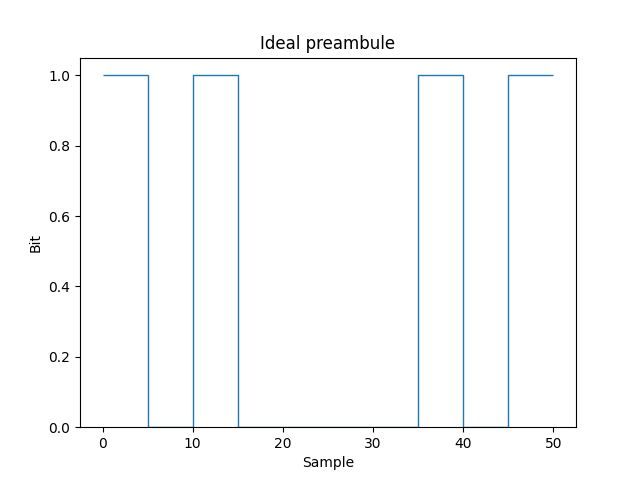

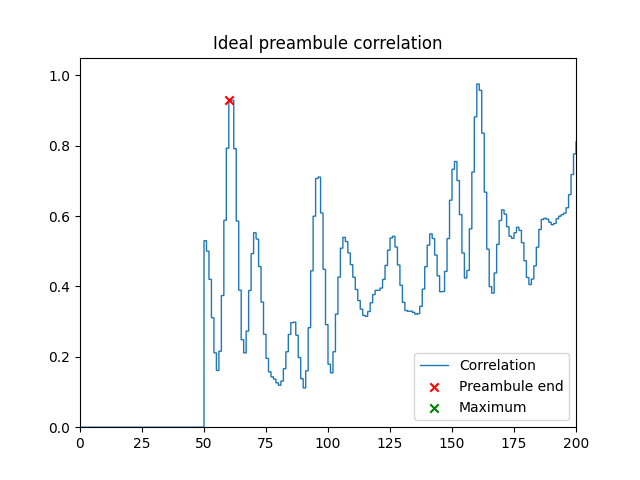

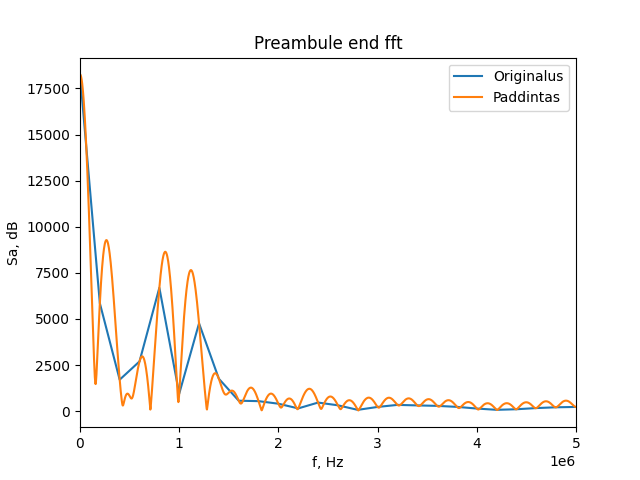

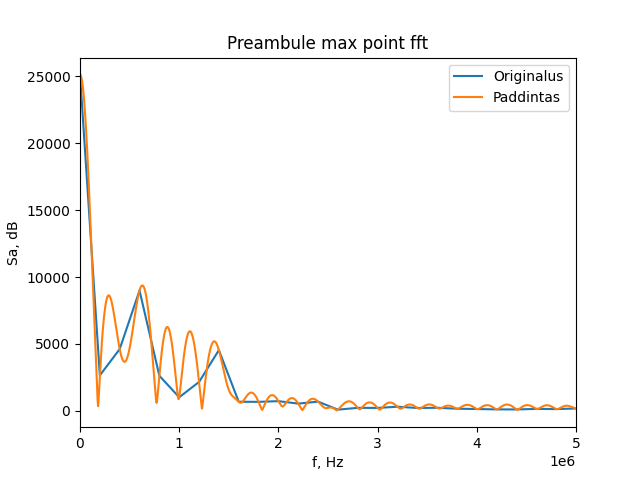

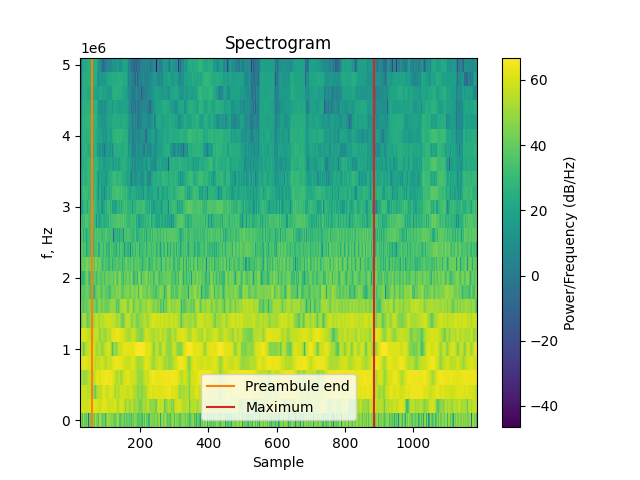

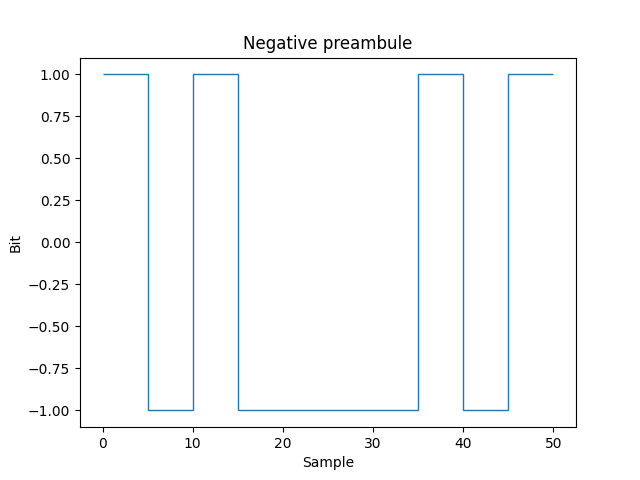

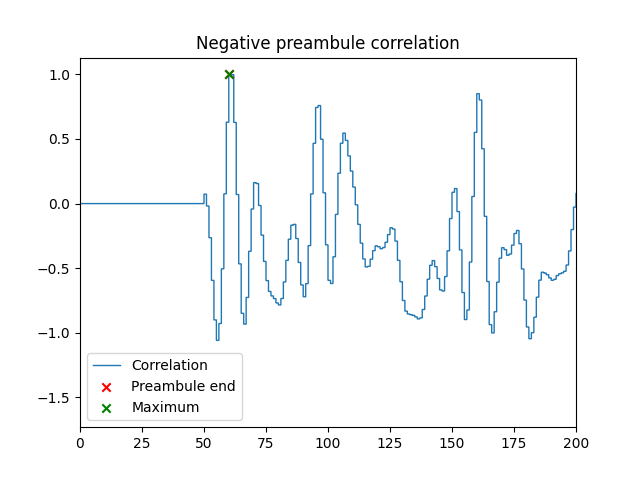

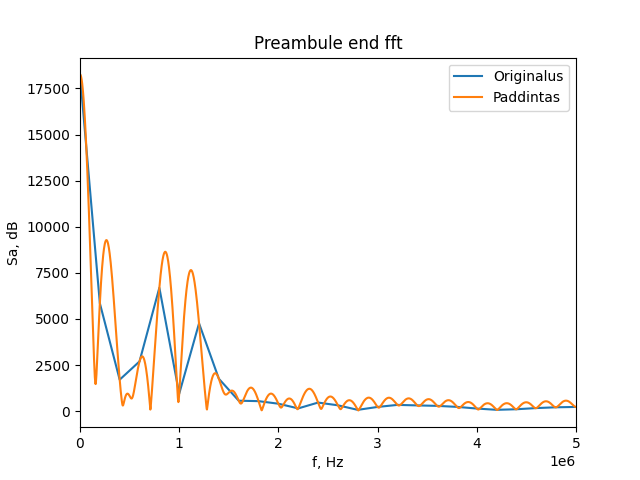

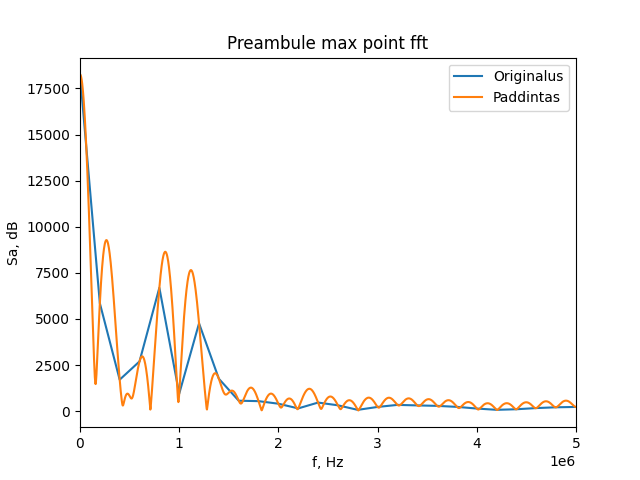

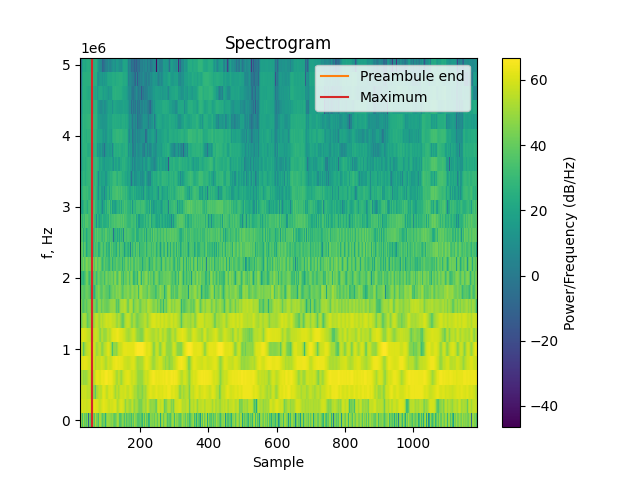

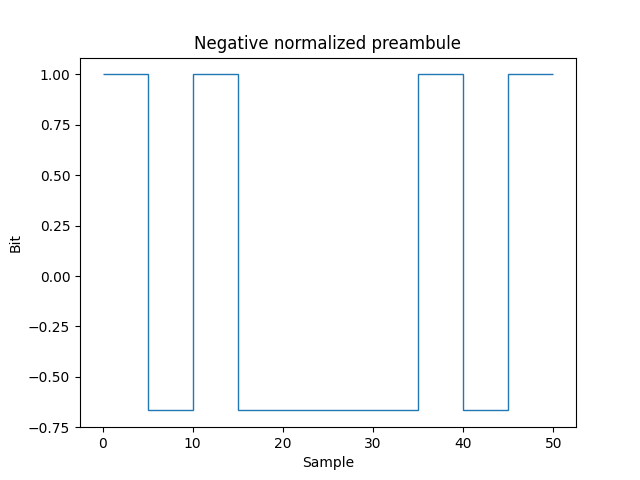

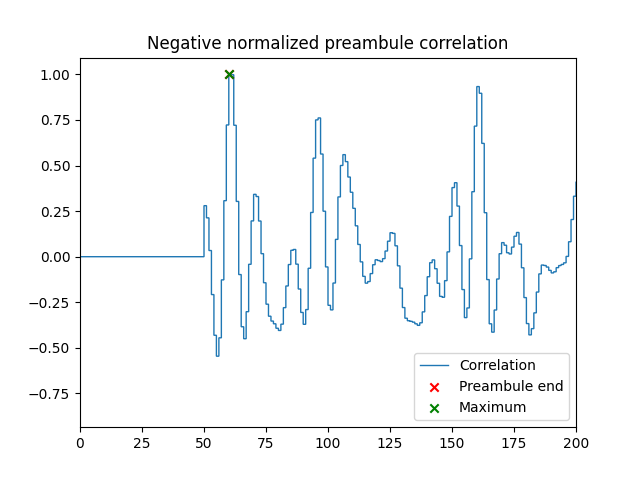

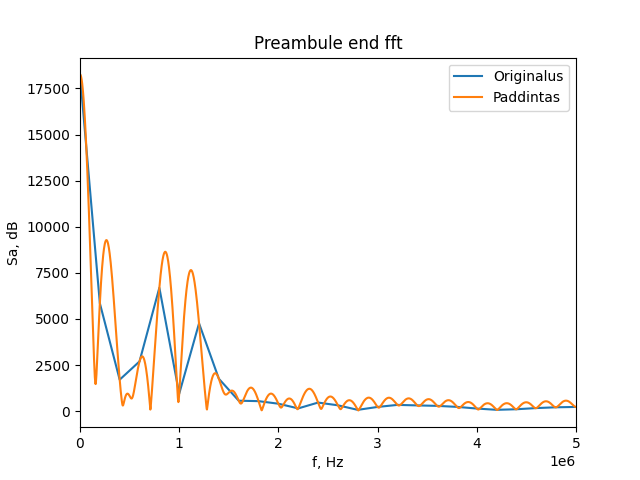

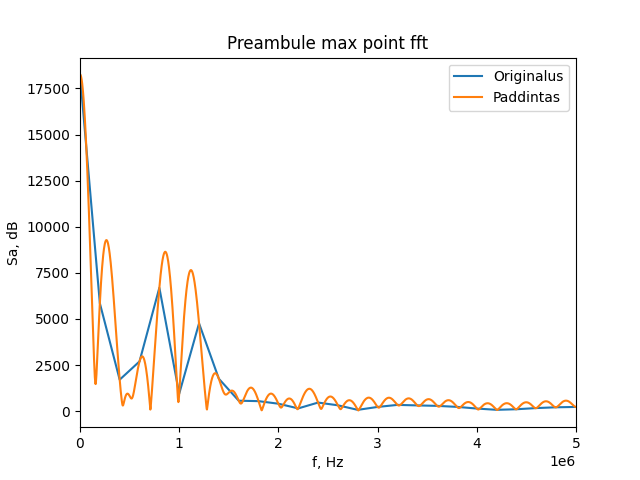

C:\Users\simon\AppData\Local\Temp\ipykernel_6996\2632196408.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


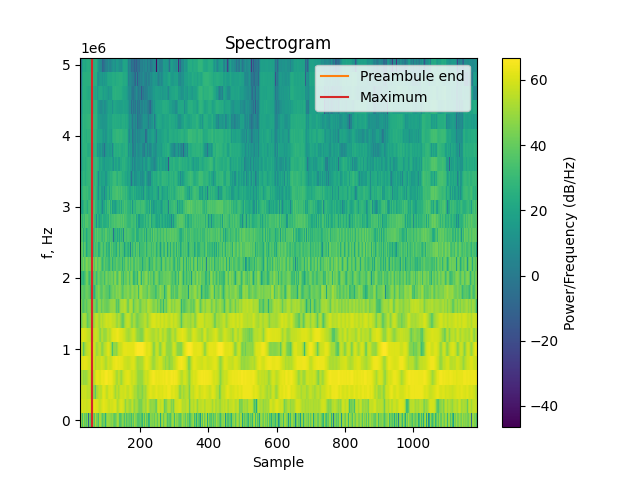

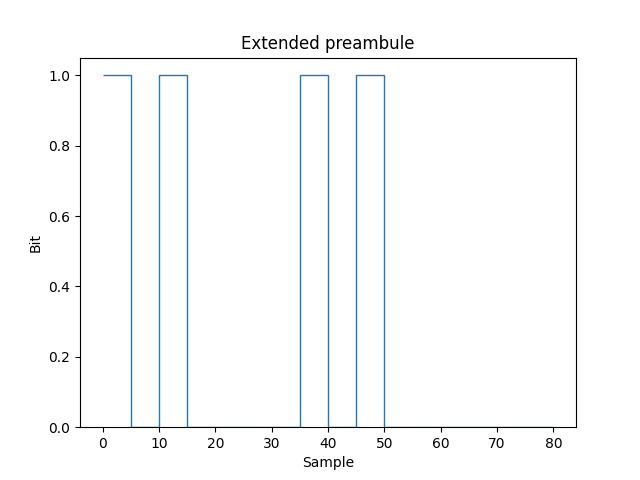

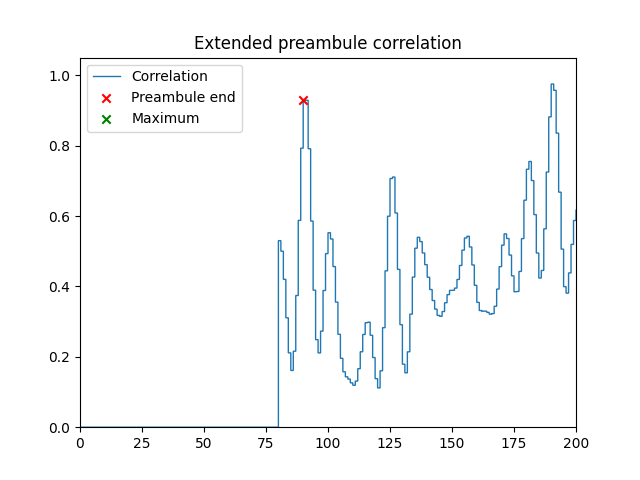

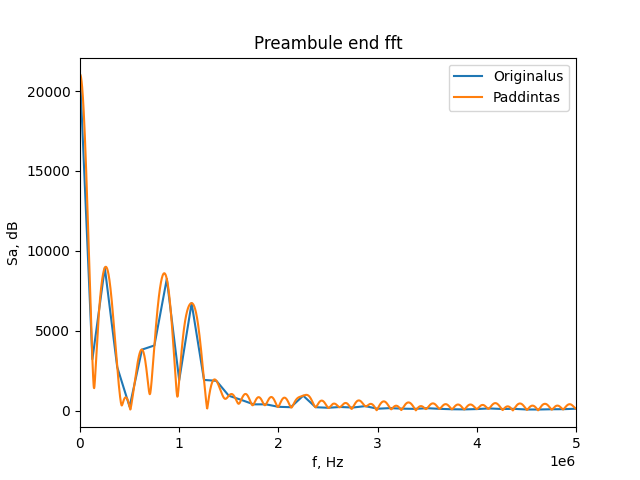

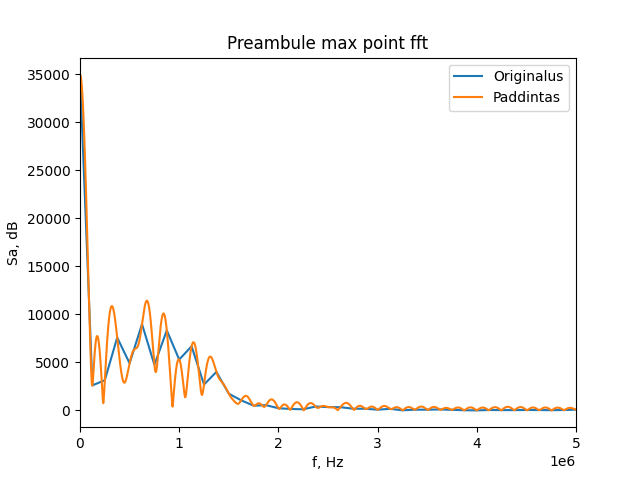

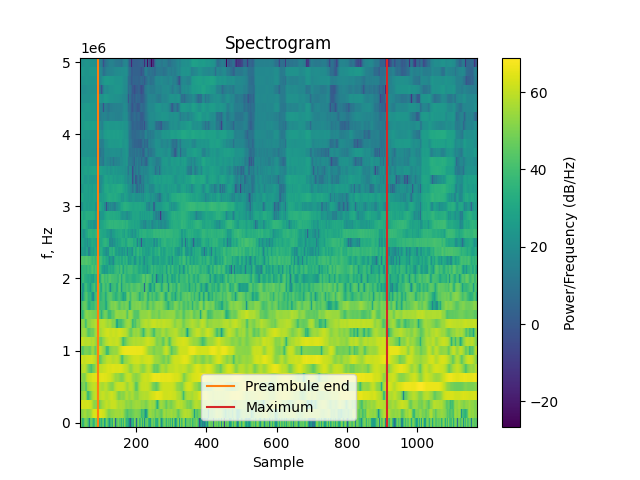

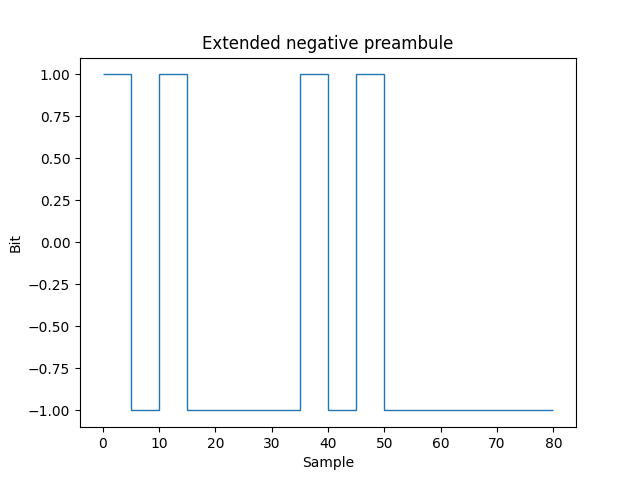

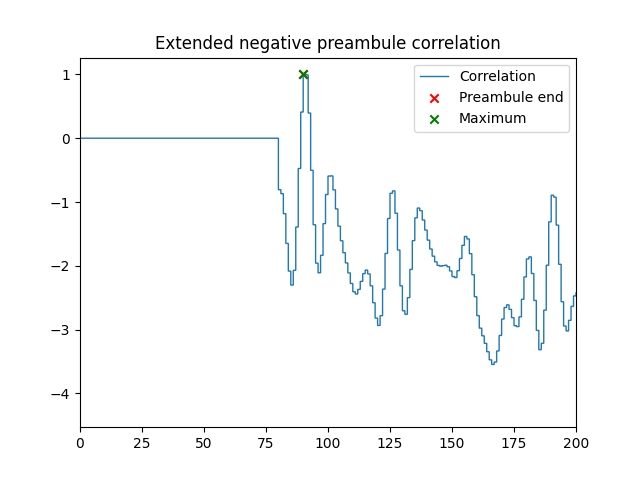

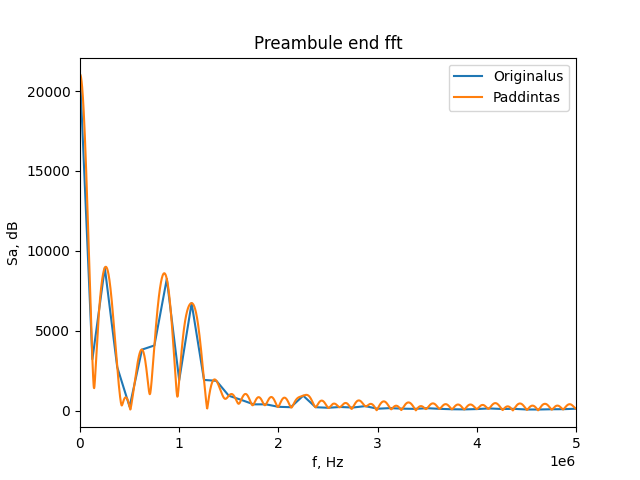

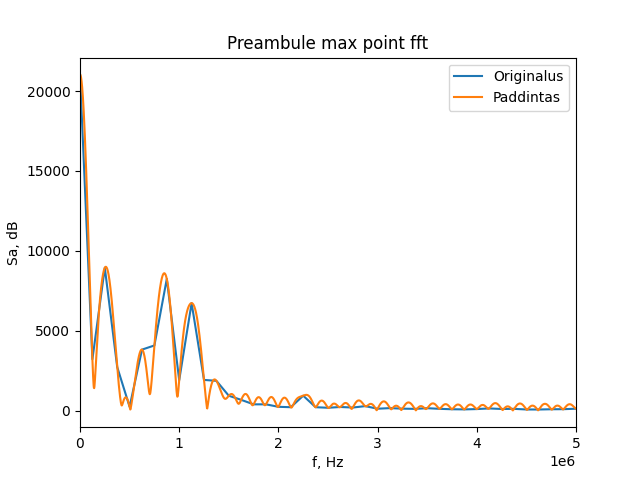

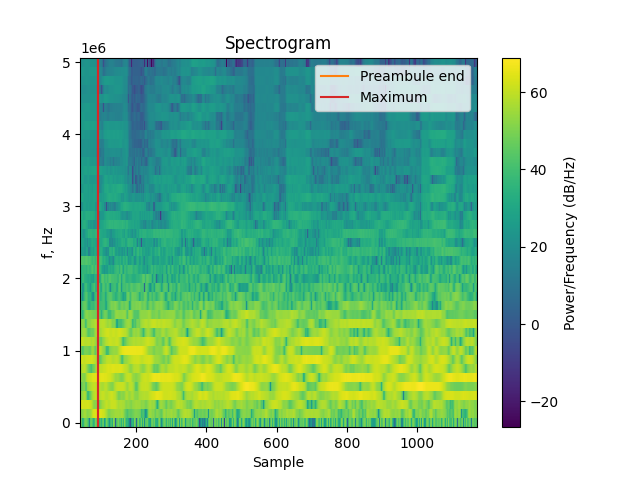

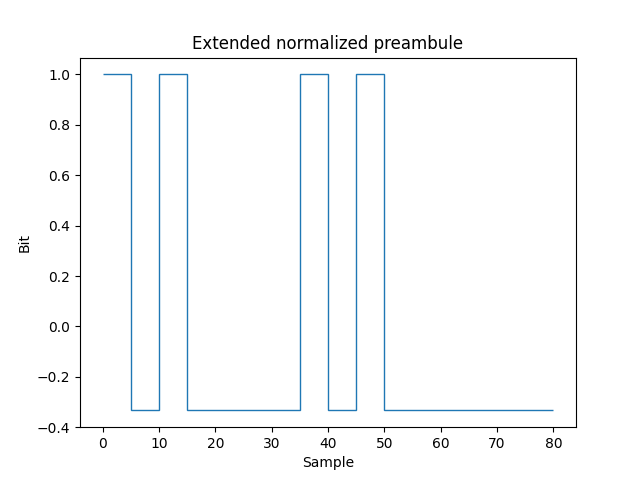

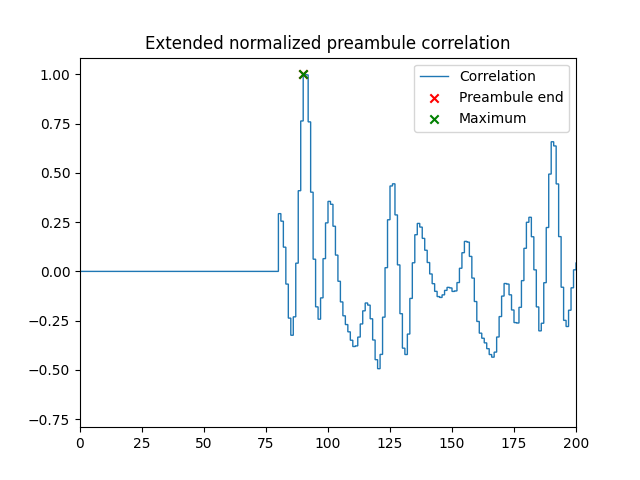

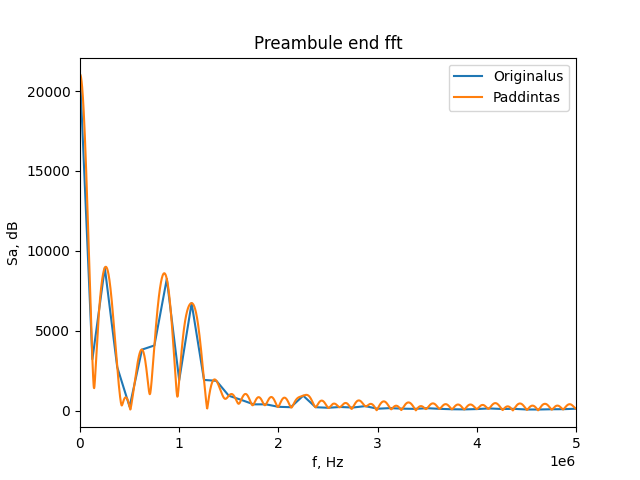

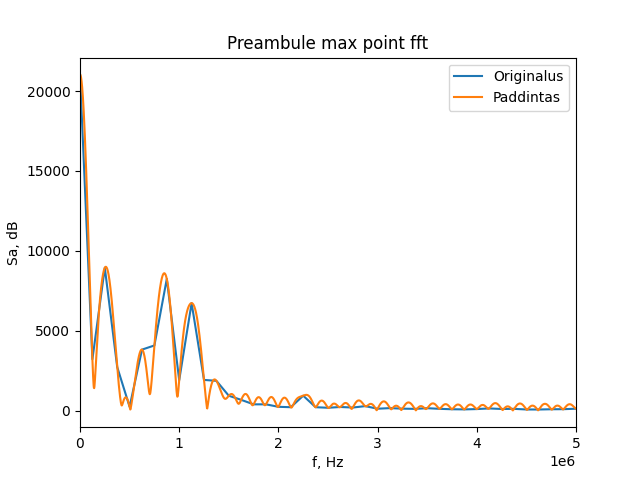

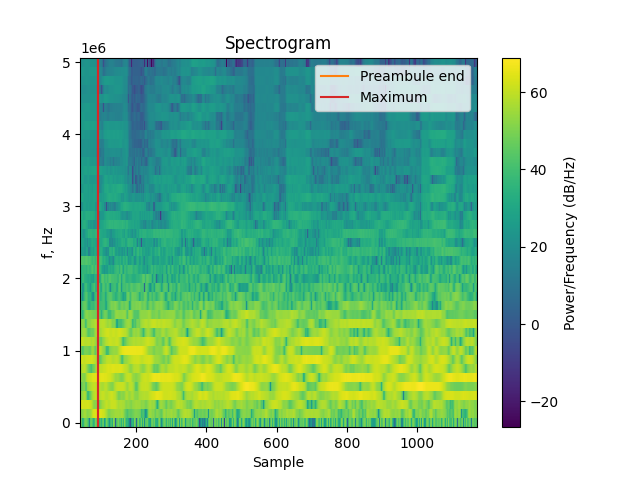

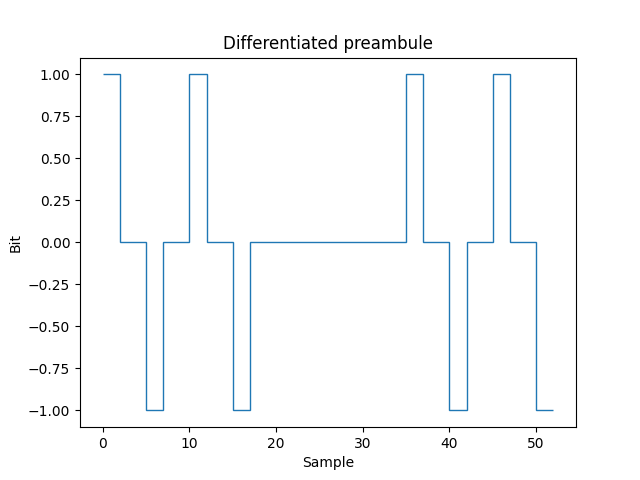

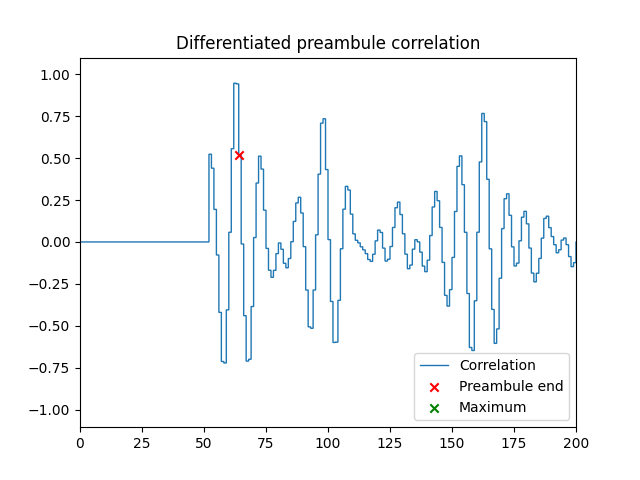

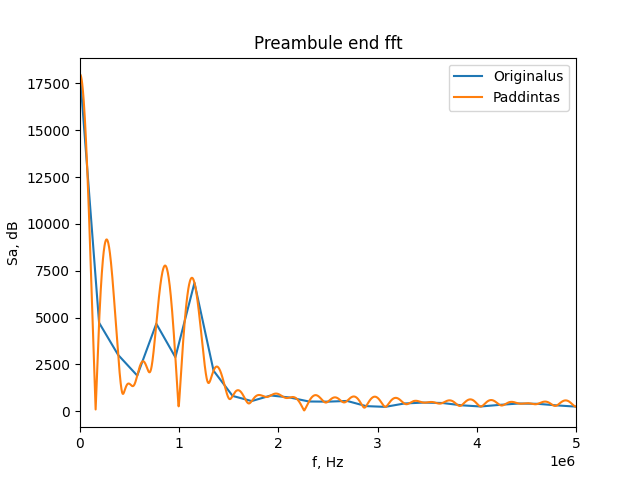

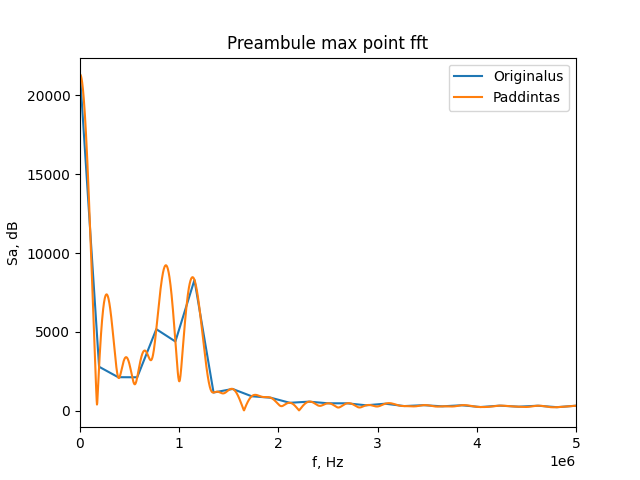

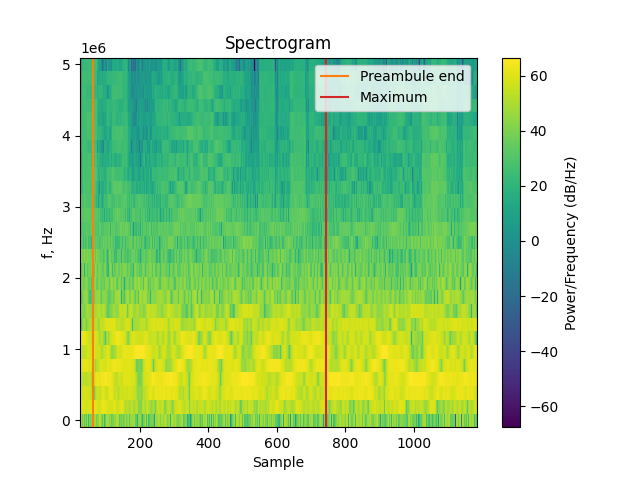

In [3]:
for preambule in preambule_list:
    expected_maximum_point_x = signal_start_pause_length + preambule.get_expected_maximum()
    curr_preambule_corr = preambule.get_correlation(digitized_signal, Correlation.Basic)
    curr_energy = get_signal_energy(digitized_signal, len(preambule.get_coefficients()))
    normalize_signal(curr_preambule_corr)
    max_idx = np.argmax(curr_preambule_corr)
    # Max and end points fft correlation
    signal_range_max = get_signal_history(digitized_signal, max_idx, len(preambule.get_coefficients()))
    corr_max_fft_f_padded, corr_max_fft_s_padded = generate_fft(signal_range_max, fd_hz, len(digitized_signal) * padding_scale)
    corr_max_fft_f, corr_max_fft_s = generate_fft(signal_range_max, fd_hz)

    signal_range_end = get_signal_history(digitized_signal, expected_maximum_point_x, len(preambule.get_coefficients()))
    preambule_end_fft_f_padded, preambule_end_fft_s_padded = generate_fft(signal_range_end, fd_hz, len(digitized_signal) * padding_scale)
    preambule_end_fft_f, preambule_end_fft_s = generate_fft(signal_range_end, fd_hz)

    # Preambule plot
    plt.figure()
    plt.stairs(preambule.get_coefficients(), baseline=None)
    plt.xlabel('Sample')
    plt.ylabel('Bit')
    plt.title(preambule.get_name() + " preambule")
    plt.show()

    # Correlation and energy plot
    plt.figure()
    plt.stairs(curr_preambule_corr, label="Correlation", baseline=None)
    plt.scatter(expected_maximum_point_x,
                curr_preambule_corr[expected_maximum_point_x],
                marker='x', color='red', label="Preambule end")
    plt.scatter(max_idx, curr_preambule_corr[max_idx], marker='x', color='green', label="Maximum")
    plt.title(preambule.get_name() + " preambule correlation")
    plt.legend()
    plt.xlim([0, 200])
    plt.show()

    #FFT plots
    plt_generator.plot_fft("Preambule end fft", fd_hz, preambule_end_fft_f, preambule_end_fft_s, 'Originalus',
                        preambule_end_fft_f_padded, preambule_end_fft_s_padded, 'Paddintas')
    plt_generator.plot_fft("Preambule max point fft", fd_hz, corr_max_fft_f, corr_max_fft_s, 'Originalus',
                        corr_max_fft_f_padded, corr_max_fft_s_padded, 'Paddintas')

    nperseg = len(preambule.get_coefficients())
    f, t_spectrogram, Sxx = signal.spectrogram(digitized_signal, 1, nperseg=nperseg, noverlap=nperseg-1)
    f_spectrogram = f * fd_hz
    plt.figure()
    plt.pcolormesh(t_spectrogram, f_spectrogram, 10 * np.log10(Sxx))
    plt.ylabel('f, Hz')
    plt.xlabel('Sample')
    plt.title('Spectrogram')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.axvline(expected_maximum_point_x, color='tab:orange', label='Preambule end')
    plt.axvline(max_idx, color='tab:red', label='Maximum')
    plt.legend()
    plt.show()
